## Εργαστηριακή Άσκηση 4: Φίλτρα Nyquist

### 1. Παραγωγή σήματος με φίλτρα Nyquist – Διαγράμματα χρόνου και συχνότητας

In [4]:
!pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 765 kB/s 
  Created wheel for scikit-commpy: filename=scikit_commpy-0.7.0-py3-none-any.whl size=58556 sha256=8baadfafe9f1201931850c91eba9b220763ad0b3b0b337a8b94ac3c9e744ebd0
  Stored in directory: /root/.cache/pip/wheels/52/2a/a2/2daff6a2d5e3b96d70fb03e5b0699ce70c98cb4c00c8107c38
Successfully built scikit-commpy


In [5]:
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as sg
import commpy as cp
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "orange", "black", "red", "lime", "teal"]) 

Στην συνέχεια συντάσονται οι συναρτήσεις που θα χρησιμοποιηθούν για την ολοκλήρωση των ζητούμενων υπολογισμών και γραφημάτων.

In [6]:
def rrcos(Ns, alpha, M):
    ## returns impulse response of rrcos
    n = np.arange(-M*Ns,M*Ns+1)
    b = np.zeros(len(n))
    Ns *= 1.0
    a = alpha
    for i in range(len(n)):
        if abs(1 - 16*a**2*(n[i]/Ns)**2) <= np.finfo(np.float).eps/2:
            b[i] = 1/2.*((1+a)*np.sin((1+a)*np.pi/(4.*a))-(1-a)*np.cos((1-a)*np.pi/(4.*a))+(4*a)/np.pi*np.sin((1-a)*np.pi/(4.*a)))
        else:
            b[i] = a/(np.pi*(1 - 16*a**2*(n[i]/Ns)**2))
            b[i] = b[i]*(np.cos((1+a)*np.pi*n[i]/Ns) + np.sinc((1-a)*n[i]/Ns)*(1-a)*np.pi/(4.*a))
    return  b

def random_bit_seq_gen(size, k):
    np.random.seed(0)
    random_bit_seq = ''
    cnt = 0
    decimal_seq = []
    for i in np.arange(0, size):
        random_bit_seq += str(np.random.randint(0, 2))
        cnt+=1
        if cnt == k:
            temp = random_bit_seq[i-k+1:i+1]
            decimal_seq.append(int(temp, 2))
            cnt = 0

    dec_random_bit_seq = np.asarray(decimal_seq)
    return random_bit_seq, dec_random_bit_seq


def gray_code(dec_seq, step, k):

    mapping = np.asarray((step/2, -step/2))
    if k+1 > 1:
        for j in np.arange(2, k+1, 1):
            mapping = np.append(mapping+(2**(j-1)*step/2), -mapping-(2**(j-1))*step/2)
    y=[]
    for i in dec_seq:
        y.append(mapping[i])

    return np.asarray(y), mapping

def cont_code(dec_seq, step, k):
    L = 2**k
    mapping = np.arange(-(L-1), (L-1)+step, step)

    y=[]
    for i in dec_seq:
        y.append(mapping[i])

    return np.asarray(y), mapping


def out_sym(yout, mapp, k):
    xr =''
    for i in yout:
        dif = abs(mapp-i)
        cnt = 0
        for j in dif:
            if j == np.amin(dif):
                break
            cnt+=1
        xr+=(str(format(cnt, "0"+str(k)+"b")))
    return xr

def Nyquist_errors(yds, k, in_mapping, x_bin):

    xout = out_sym(yds, in_mapping, k=k)
    err = 0
    for i in np.arange(0, len(xout), 4):
        if x_bin[i:i+4] != xout[i:i+4]:
            err+=1
    return err

def Nyquist_transm(Nsymb, nsamp, rolloff, delay, k, plots, code='gray', noise=True, EbN0_db=0, noise_power=0):
    L = 2**k
    np.random.seed(0)
    filtorder = 2*delay*nsamp

    h_rc = rrcos(nsamp, rolloff, delay)



    x_bin, x_sym = random_bit_seq_gen(k*Nsymb, k=k)

    if code=='gray':
        y1, mmap = gray_code(dec_seq=x_sym, step=2, k=k)
    else:
        y1, mmap = cont_code(dec_seq=x_sym, step=2, k=k)

    y = np.zeros((nsamp*Nsymb))
    y[::nsamp] = y1

    ytx = np.convolve(y, h_rc)

    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    if noise:
        y_noisy = cp.channels.awgn(ytx, snr_dB=SNR_db)
    else:
        y_noisy = ytx

    if noise_power !=0:
        y_noisy = ytx+np.random.normal(0, np.sqrt(noise_power),len(ytx))

    yrx = np.convolve(y_noisy, h_rc)

    yrx = yrx[filtorder: len(yrx)-filtorder]
    yds = []
    for i in np.arange(0, Nsymb*nsamp, nsamp):
        yds.append(yrx[i])
    if plots:
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        plt.title('Root Raised Cosine filter impulse response')
        plt.stem(h_rc, basefmt='black', use_line_collection=True)
        plt.grid()
        plt.show()
    
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        plt.stem(yrx[0:10*nsamp], basefmt='black', use_line_collection=True, label='Receiver filter output before downsampling')
        plt.stem(np.arange(0, 10*nsamp, nsamp), y1[0:10], label='Gray encoded signal before upsampling', use_line_collection=True, markerfmt='C1o', linefmt='C1', basefmt='black')
        plt.legend()
        plt.grid()
        plt.show()

        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        f1, Pxx1 = sg.welch(yrx, nsamp)
        plt.plot(f1, Pxx1)
        plt.title('Periodogram of the receiver΄s output')
        plt.grid()
        plt.show()
        
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        f1, Pxx1 = sg.welch(y1, nsamp)
        plt.plot(f1, Pxx1)
        plt.title('Periodogram of the signal before upsampling')
        plt.grid()
        plt.show()
        
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        f1, Pxx1 = sg.welch(h_rc, nsamp)
        plt.plot(f1, Pxx1)
        plt.title('Periodogram of the Nyquist filter')
        plt.grid()
        plt.show()

    errors = Nyquist_errors(yds=yds, k=k, in_mapping=mmap, x_bin=x_bin)

    if noise_power !=0:
        ber_par = errors/Nsymb/np.log2(L)
        return ber_par

    return errors

def ber_sim(Nsymb, k, delay, rolloff, code='gray'):
    L = 2**k
    ber = []
    for index in range (0,21):
        ber.append(Nyquist_transm(Nsymb=Nsymb, nsamp=16, rolloff=rolloff, delay=delay, EbN0_db=index, k=k, plots=False, code=code)
                    /Nsymb/np.log2(L))
    return ber

def get_Nyquist_params(W, No, transm_rate, max_ber):
    baud_rate = transm_rate / np.log2(16)
    Td = 1 / baud_rate
    roll_off = 2 * W / baud_rate - 1
    total_noise_power = No * W
    n_out = 0; d_out = 0
    for ns in np.asarray((4, 8, 16, 32, 64)):
        for i in np.arange(3, 24, 3):
            de = int(round(i * Td))
            if (Nyquist_transm(Nsymb=10000, nsamp=ns, rolloff=roll_off, delay=de, k=4, plots=False,
                               noise_power=total_noise_power, noise=False))*transm_rate <= max_ber:

                print(ns, de, (Nyquist_transm(Nsymb=10000, nsamp=ns, rolloff=roll_off, delay=de, k=4, plots=False,
                               noise_power=total_noise_power, noise=False))*transm_rate)
                n_out = ns; d_out = de
                break
    print("Για τις δοσμένες παραμέτρους, προκύπτει φίλτρο τάξης: ", 2*n_out*d_out, " με roll-off: ", roll_off)
    return n_out, roll_off, d_out





### 1. Παραγωγή σήματος με φίλτρα Nyquist – Διαγράμματα χρόνου και συχνότητας

Παρακάτω φαίνονται τα γραφήματα:
####  (i) της κρουστικής απόκρισης του φίλτρου Nyquist με roll-off = 0.35 και τάξη φίλτρου 128
####  (ii) το σήμα στην έξοδο του προσαρμοσμένου φίλτρου του δέκτη σε κοινό διάγρμμα με τα αντίστοιχα δείγματα του σήματος
####  (iii) το φάσμα του σήματος στον δέκτη, το φάσμα του αρχικού σήματος και το φάσμα του φίλτρου

Στο δεύτερο γράφημα φαίνεται ξεκάθαρα η υπερδειγμάτιση του σήματος καθώς επίσης και το πόσο μικρή είναι η απόκλιση μεταξύ αρχικών και τελικών τιμών, αφού με την χρήση του συγκεκριμένου φίλτρου μορφοποίησης παλμών εξασφαλίζεται μηδενική παρεμβολή μεταξύ των παλμών της ακολουθίας.

Όσον αφορά το φάσμα του σήματος στον δέκτη, με την παρατήρηση και την σύγκριση των αντίστοιχων περιοδογρμμάτων του αρχικού σήματος πριν την υπερδειγμάτιση και του φίλτρου Nyquist, φαίνεται ότι όλη η ισχύς του σήματος, όταν αυτό περάσει από τα δύο φίλτρα του πομπού και του δέκτη, συγκεντρώνεται στις συχνότητες του φίλτρου. 

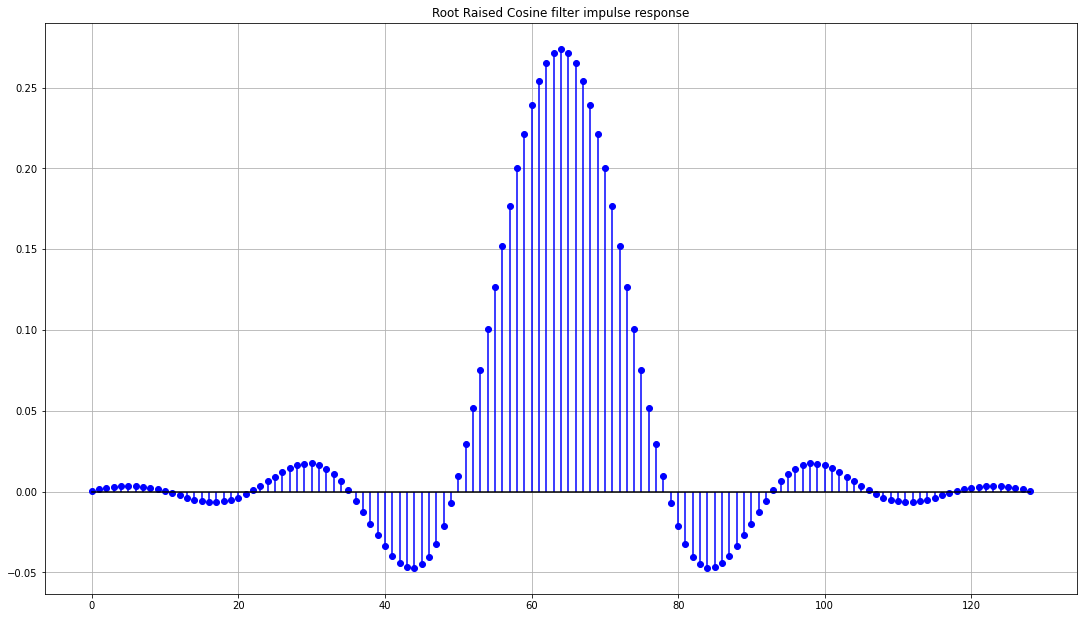

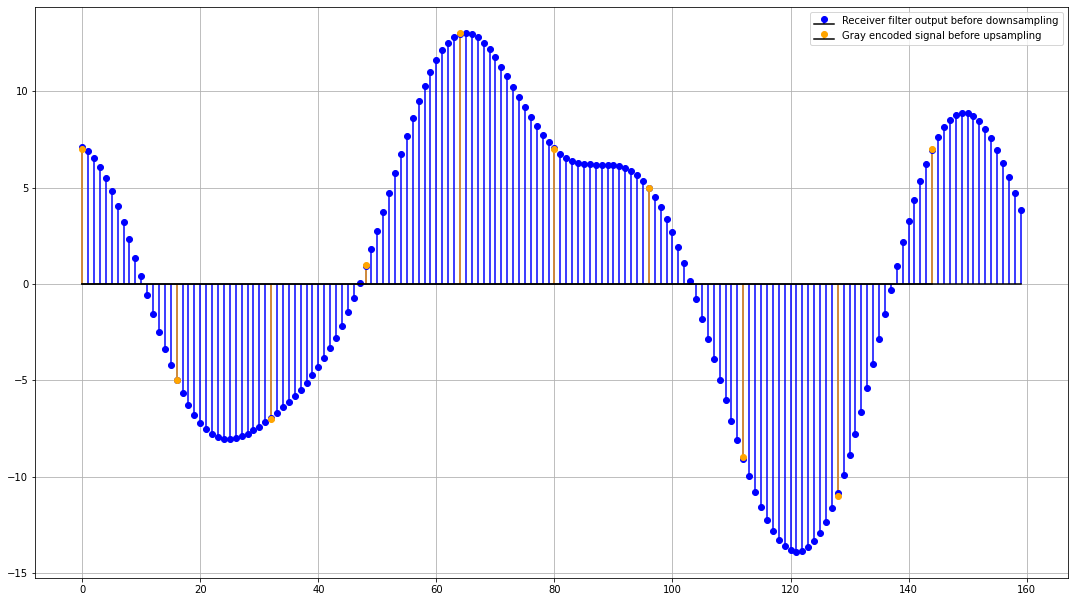

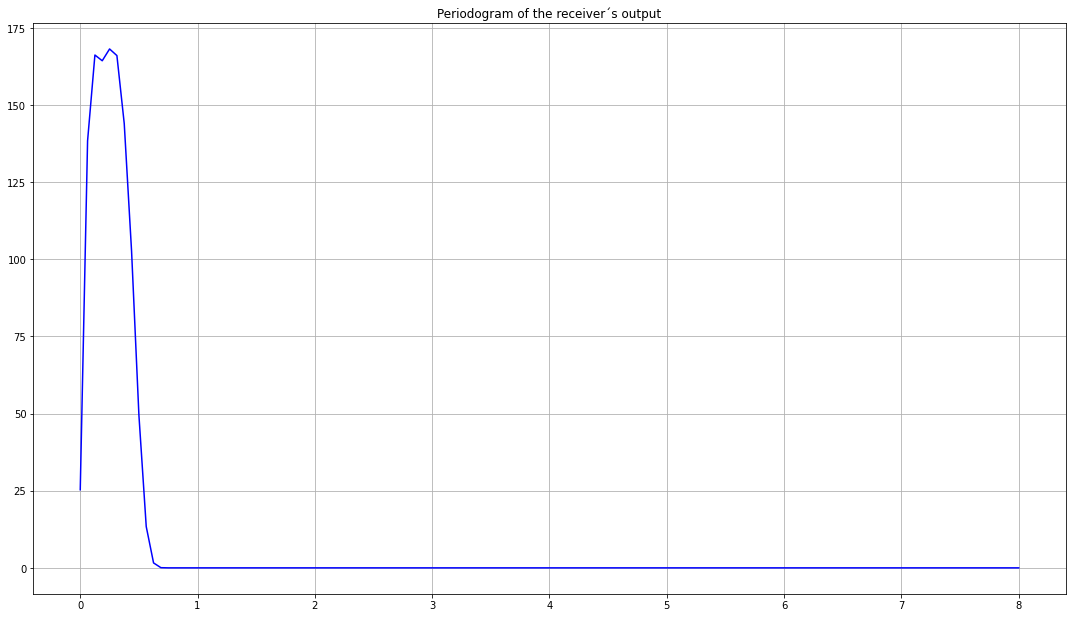

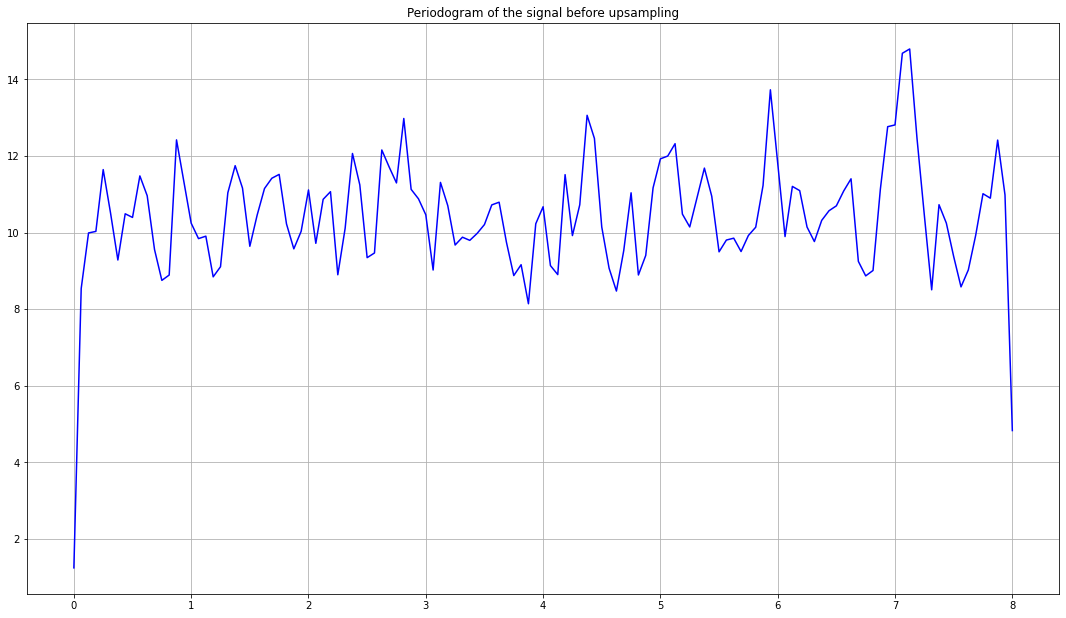

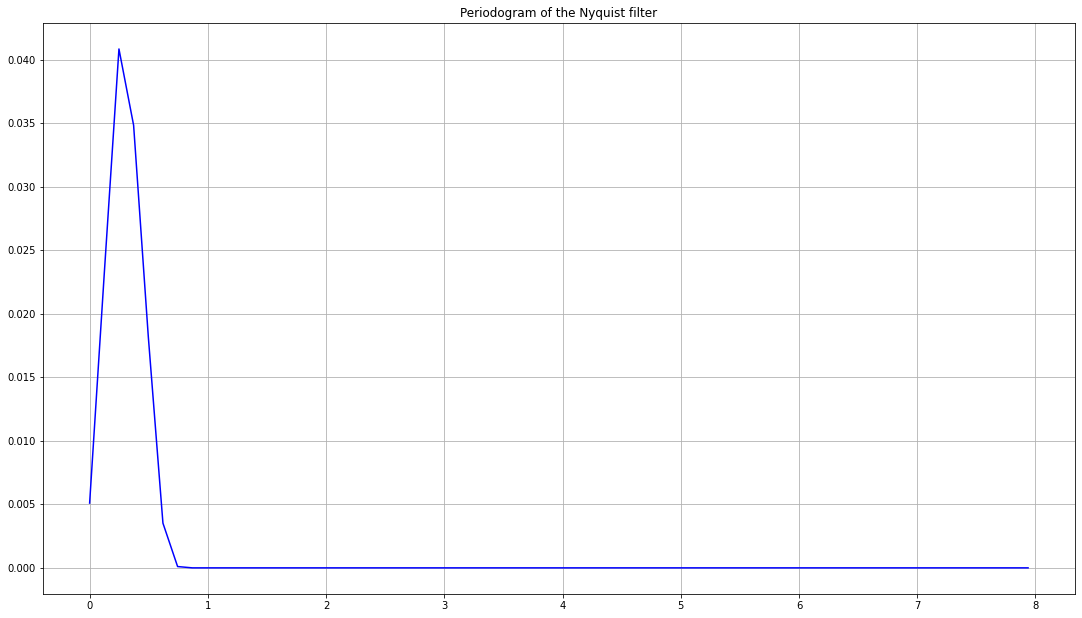

In [7]:
e1 = Nyquist_transm(Nsymb=10000, nsamp=16, rolloff=0.35, delay=4, k=4, plots=True, code='gray', noise=False)

### 2. Υπολογισμός επίδοσης BER vs Eb/No.
#### Μελέτη της επίδρασης των παραμέτρων: τάξη φίλτρου Nyquist και roll-off

Παρακάτω ακολουθούν οι animated καμπύλες BER-Eb/No. Για τις ζητούμενες περιπτώσεις του παράγοντα roll-off σε κάθε μία από τις παρακάτω γραφικές παραστάσεις, παρουσιάζεται η εξέλιξη του BER σε σχέση με την θεωρητική καμπύλη BER-Eb/No για 16-ASK για τις διάφορες τάξης φίλτρου. Τα δεδομένα που παρίστανται γραφικά λαμβάνονται από την εξομοίωση που πραγματοποιείται από την συνάρτηση ber_sim() η οποία κάθε φορά που καλέιται παίρνει διαφορετικό group_delay και επομένως αλλάζει αναλόγως την τάξη του φίλτρου. 

Παρατηρείται ότι με τν άυξηση του παράγοντα roll-off η καμπύλη προσομοίωσης προσεγγίζει πιο γρήγορα (με την αύξηση της τάξης του φίλτρου) την θεωρητική καμπύλη BER-Eb/N. Το παραπάνω είναι λογικό εάν ληφθεί υπόψιν η γραφική και η μαθηματική μορφή της κρουστικής απόκρουσης του φίλτρου, από την οποία φαίνεται ότι με την άυξηση του παράγοντα roll-off αυξάνεται ο ρυθμός με τον οποίο μηδενίζονται οι πλευρικοί λοβοί και αντίστοιχα αυξάνεται και η εξασθένηση στην ζώνη αποκοπής. Παρ'όλα αυτά σημειώνεται ότι για λόγους αποτελεσματικότητας εύρους ζώνης οι μεγάλες τιμές του roll-off δεν είναι πάντα ιδανικές.

Αντίστοιχα παρατηρώντας την μεταβολή της καμπύλης προρομοίωσης για τις διάφορες τάξεις του φίλτρου (η οποία όπως αναφέρθηκε αλλάζει μέσω της μεταβολής του group_delay), λαμβάνεται ότι με την αύξηση της τάξης του φίλτρου (και αντίστοιχα της καθυστέρησης), η καμπύλη προσομοίωσης προσεγγίζει όλο και περισσότερο την θεωρητική. Αυτό είναι επίσης αναμενόμενο, καθώς με την άυξηση της καθυστέρησης αυξάνεται και η εξασθένηση στην ζώνη αποκοπής.

In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.special import erfc


fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
k = 4
L = 2**k


F = np.empty(shape=[4, 21])
ds = np.asarray((2, 4, 8, 16))
for i in np.arange(0, 4, 1):
    F[i, :]=ber_sim(Nsymb=10000, k=k, delay=ds[i], rolloff=0.1)

line=ax.semilogy(F[0, :],'o')[0]

def animate(i):
    ds = np.asarray((64, 128, 256, 512))
    line.set_ydata(F[i, :])
    ax.set_title('BER to Eb/No for filter order = '+str(ds[i])+' and rolloff = 0.1')

anim = FuncAnimation(
    fig, animate, interval=1000, frames=4)

plt.draw()

plt.grid(True,which='both')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")

EbNo_db = np.arange(0,21,1)
EbNo = 10**(EbNo_db/10)
ber_theoretical = (((L-1)/L)*erfc(np.sqrt(EbNo*(3*np.log2(L))/(L**2-1))))/k
plt.semilogy(ber_theoretical)

plt.legend(['Experimental','Theoretical'], loc='lower left')
#anim.save('BER-01.gif', writer='imagemagick')
plt.close()



In [9]:

HTML(anim.to_jshtml())


In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
k = 4
L = 2**k


F = np.empty(shape=[4, 21])
ds = np.asarray((2, 4, 8, 16))
for i in np.arange(0, 4, 1):
    F[i, :]=ber_sim(Nsymb=10000, k=k, delay=ds[i], rolloff=0.35)

line=ax.semilogy(F[0, :],'o')[0]

def animate(i):
    ds = np.asarray((64, 128, 256, 512))
    line.set_ydata(F[i, :])
    ax.set_title('BER to Eb/No for filter order = '+str(ds[i])+' and rolloff = 0.35')

anim = FuncAnimation(
    fig, animate, interval=1000, frames=4)

plt.draw()

plt.grid(True,which='both')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")

EbNo_db = np.arange(0,21,1)
EbNo = 10**(EbNo_db/10)
ber_theoretical = (((L-1)/L)*erfc(np.sqrt(EbNo*(3*np.log2(L))/(L**2-1))))/k
plt.semilogy(ber_theoretical)

plt.legend(['Experimental','Theoretical'], loc='lower left')
#anim.save('BER-035.gif', writer='imagemagick')
plt.close()



In [11]:
HTML(anim.to_jshtml())


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
k = 4
L = 2**k


F = np.empty(shape=[4, 21])
ds = np.asarray((2, 4, 8, 16))
for i in np.arange(0, 4, 1):
    F[i, :]=ber_sim(Nsymb=10000, k=k, delay=ds[i], rolloff=0.9)

line=ax.semilogy(F[0, :],'o')[0]

def animate(i):
    ds = np.asarray((64, 128, 256, 512))
    line.set_ydata(F[i, :])
    ax.set_title('BER to Eb/No for filter order = '+str(ds[i])+' and rolloff = 0.9')

anim = FuncAnimation(
    fig, animate, interval=1000, frames=4)

plt.draw()

plt.grid(True,which='both')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")

EbNo_db = np.arange(0,21,1)
EbNo = 10**(EbNo_db/10)
ber_theoretical = (((L-1)/L)*erfc(np.sqrt(EbNo*(3*np.log2(L))/(L**2-1))))/k
plt.semilogy(ber_theoretical)

plt.legend(['Experimental','Theoretical'], loc='lower left')
#anim.save('BER-09.gif', writer='imagemagick')
plt.close()



In [ ]:
HTML(anim.to_jshtml())

### 3. Επίδραση του τρόπου κωδικοποίησης: Gray ή άλλη

Στο παρακάτω διάγραμμα παρουσιάζονται οι καμπύλες BER-Eb/No για τις 16-ASK και 8-ASK με 2 κωδικοποιήσεις, Gray και απλή συνεχόμενη κωδικοποίση, και συγκρίνονται με τις αντίστοιχες θεωρητικές καμπύλες. Παρατηρείται ότι και στις δύο περιπτώσεις, η χρήση της κωδικοποίσης Gray έχει ως αποτέλεσμα την μικρότερη απόκλιση από την θεωρητική καμπύλη. Με την κωδικοποίση Gray τα γειτονικά στοιχεία διαφέρουν κατά 1 bit και επομένως σχεδόν εξαφανίζονται τα τυχών σφάλματα στον φωρατή του δέκτη που ανιχνέυει τις ελάχιστες αποστάσεις για την αντιστοίχηση κωδικολέξεων. Επιπροσθέτα σε ένα πιθανό σενάριο όπου χρησιμοποιούταν κωδικοποίση Gray σε συνδιασμό με κάποιο forward error correction για την διόρθωση λαθών ενός bit, η διάταξη είναι πόλυ λιγότερο επιρεπής στην επιρροή θορύβου.

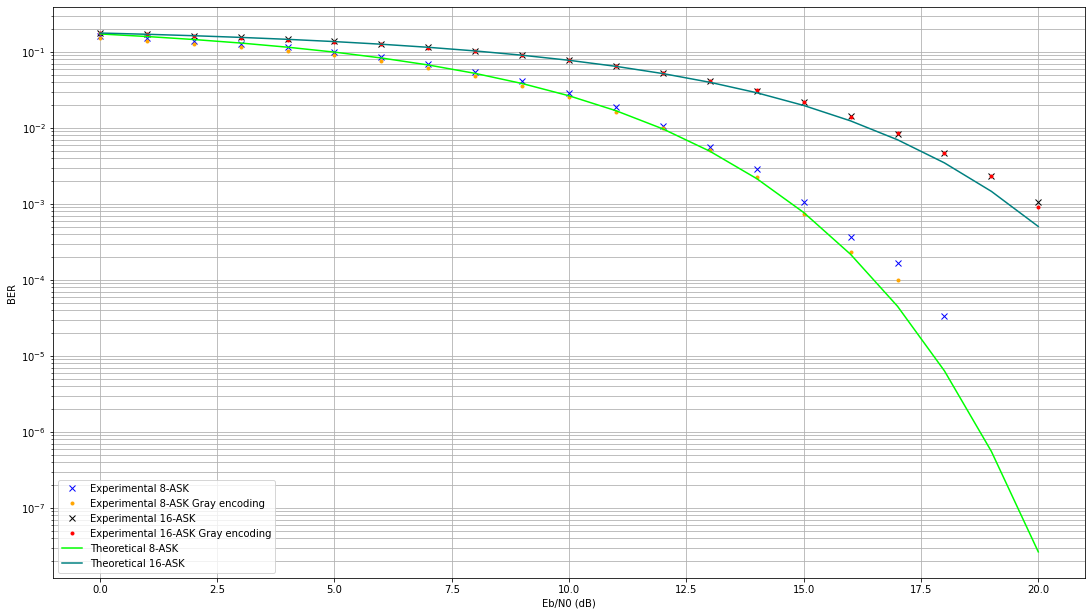

In [ ]:
from scipy.special import erfc
from matplotlib import cm


fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
k1 = 3
L1 = 2**k1

k2 = 4
L2 = 2**k2

ax.semilogy(ber_sim(Nsymb=10000, k=k1, delay=4, rolloff=0.35, code='cont'), 'x')
ax.semilogy(ber_sim(Nsymb=10000, k=k1, delay=4, rolloff=0.35, code='gray'), '.')

ax.semilogy(ber_sim(Nsymb=10000, k=k2, delay=4, rolloff=0.35, code='cont'), 'x')
ax.semilogy(ber_sim(Nsymb=10000, k=k2, delay=4, rolloff=0.35, code='gray'), '.')

plt.grid(True,which='both')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")

EbNo_db = np.arange(0,21,1)
EbNo = 10**(EbNo_db/10)
ber_theoretical1 = (((L1-1)/L1)*erfc(np.sqrt(EbNo*(3*np.log2(L1))/(L1**2-1))))/k1

ber_theoretical2 = (((L2-1)/L2)*erfc(np.sqrt(EbNo*(3*np.log2(L2))/(L2**2-1))))/k2

plt.semilogy(ber_theoretical1)
plt.semilogy(ber_theoretical2)

plt.legend(['Experimental 8-ASK','Experimental 8-ASK Gray encoding','Experimental 16-ASK',
            'Experimental 16-ASK Gray encoding', 'Theoretical 8-ASK','Theoretical 16-ASK'], loc='lower left')
plt.show()

### 4. Υπολογισμός παραμέτρων συστήματος


In [ ]:
nsamp, a, delay = get_Nyquist_params(1, 100 * 10 ** (-6), 6, 2*10**-3)

16 6 0.0009
Για τις δοσμένες παραμέτρους, προκύπτει φίλτρο τάξης:  192  με roll-off:  0.33333333333333326
